# Convolution


In [84]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import firwin
from IPython.display import display, Audio, Image
import matplotlib.pyplot as plt

Convolution can be used as cross-synthesis, a process through which the sonic characteristics of one signal is used to alter the character of another. 

Mathematically, convolution is defined as
$$(f * g)(t) = \int_{-\infty}^\infty f(\tau) g(t - \tau) d\tau$$

But, we can think about it "blending" two functions of signals. The integral expresses the amount of overlap of one function as its shifted over the other.

<img src="https://docs.scipy.org/doc/scipy/_images/scipy-signal-convolve-1.png" alt="Image of feedfoward comb filter block diagram" width="500" />

## Reverb

We'll start looking at convolution through the lens of convolution reverb. 

In convolution reverb, we "combine" an impulse response of a room with our input signal.

The impulse response is the measure of a room's response over time. It is characterized by the sum of filtered and delayed reflections.  

An impulse response is created by playing a quick sound, or an impulse, in a space. The impulse is usually a short, percussive sound (a starter pistol, a clapboard / slate, a balloon popping, etc.) but can sometimes be a more sustained sound that moves through the frequency spectrum (e.g., a sine sweep). 

People record and collect these impulse responses (though researchers also try to predict and model the impulse responses themselves) and they form the basis of many reverb plugins in DAWs. These impulse responses are then used to transform an input signal to recreate the timbre of a particular space or setting.

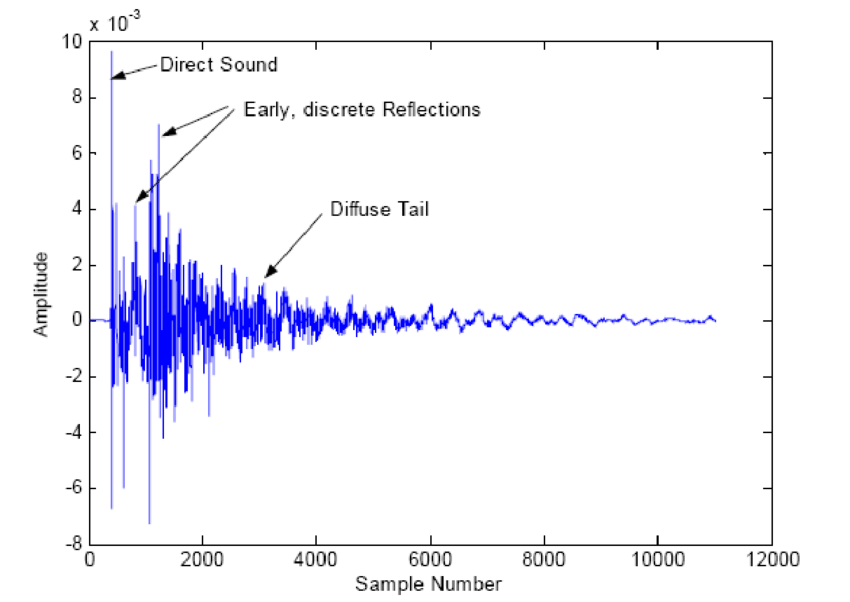

In [3]:
Image(url="https://audiotech2images.s3.us-east-2.amazonaws.com/IRshortReverb.png", embed=True, width=500)

Remember reverb is different than a simple delay or echo.  Reverb is the result of many reflecting sound waves moving through a medium and decaying over time. The reverberation (and impulse response) is determined by size, shape, and materials in the room which determine how sound waves are reflected, absorbed, and diffused.

Reverb is made up of the direct sound, early reflections, and late reflections, where
- Direct signal -> source to ear
- Early reflections -> source to “wall” to ear
- Late reflections -> source to “wall” to ”wall” etc

When an impulse is produced in a space, the way the space responds to each frequency in that impulse can vary greatly. Some frequencies might be absorbed more than others, some might be reflected more efficiently, and some might cause resonances at specific points in the space. These variations in response are essentially the acoustic signature of the space and are captured in the impulse response. 

## Convolution of the frequency spectra

When we convolve an impulse response (IR) with another signal, we are multiplying their components in the frequency domain. This ultimately has the effect of applying the frequency-dependent changes of the IR to the other signal, such that the signal takes on the frequency response of the IR.

Let's listen to an example first. We will take the sound of a (dry) dog bark and convolve it with an impulse response to create a bark with reverb:

In [ ]:
# input signal
(fs, bark) =  read('../audio/dog_bark_dry.wav')
bark = bark[:,0] # bark is stereo but we only want one channel right now

# impulse one
(fs2, ir) =  read('../audio/impulse-response.wav')

# impulse two
(fs3, ir2) = read('../audio/IR_medium.wav')
ir2 = ir2[:,0] # ir2 is stereo but we only want one channel right now

# dog bark alone
Audio(bark, rate=fs)
# Impulse 1 response 
Audio(ir, rate=fs2)
# Impulse 2 response 
Audio(ir2, rate=fs3)

We'll use the numpy function `convolve` to convolve the two time series. 

First, we have to normalize the values and convert to floating point due to the nature of scaling problems with convolution:

In [9]:
#convert np.int16 files into float32
def convert_to_float(file):
    file_c = file.astype(np.float32, order='C')/32768.0 #divide by max int
    return(file_c)

bark = convert_to_float(bark)
ir = convert_to_float(ir)
ir2 = convert_to_float(ir2)

In [10]:
c1 = np.convolve(bark, ir)
Audio(c1, rate=fs)

In [11]:
c2 = np.convolve(bark, ir2)
Audio(c2, rate=fs)

Outside of reverb, we can also apply convolution to two different audio signals. This is for the cross-synthesis feature of blending two sounds and works well for rhythmic sounds.

In [20]:
(fs4, drums) = read('../audio/80spopDrums.wav')
drums = convert_to_float(drums)
Audio(drums, rate=fs4)

In [21]:
c3 = np.convolve(bark, drums)
Audio(c3, rate=fs)

Notice that it took much longer to process that convolution than the others.

Convolution is very processing-intensive. It takes up a lot of memory and processing time. Let's work through the math to figure out why.


Convolution essentially maps the interaction of two functions (f1, f2) over time to a third function (f1 * f2). In our case, "time" here will be represented by the incrementation of samples. We understand that each sample number is processed at a different time, T. 

What we need to do is to multiply every sample value from our input signal to each value of our impulse response. We then add those signals together but shifted in increments of time, T, where T is just one sample.
#### Convolution definition:
$$(f * g)(t) = \int_{-\infty}^\infty f(\tau) g(t - \tau) d\tau$$

Let's do this manually.

We'll start by two signal vectors f and g 

In [22]:
f = np.array([2,4,3,6])
g = np.array([1,5,2,3,4])

We need to multiply signal g by signal f over time and add at each time position. This looks like sliding signal g across signal f. The result is the output of the convolution at that time position.

| 2  | 4  | 3  | 6  |   |   |   |   | Result|
|-|-|-|-|-|-|-|-|-|
| 1  |   |   |  |  |   |  |   | 2(1) = 2
|  5 | 1  |  |   |   |   |   |   | 2(5) + 4(1) = 14
|  2 | 5 |  1 |   |   |   |   |   | 2(2) + 4(5) + 3(1) = 27
|  3 | 2  | 5  | 1  |   |   |   |   |2(3) + 4(2) + 3(5) + 6(1) = 35
|  4 | 3  | 2  | 5  |   |   |   |   |2(4) + 4(3) + 3(2) + 6(5) = 56
|   | 4  | 3  | 2  |  |   |   |   |4(4) + 3(3) + 6(2) = 56
|   |   | 4  | 3  |  |   |   |   |4(4) + 3(3) + 6(2) = 37
|   |   |   | 4  |  |   |   |   |4(4) + 3(3) + 6(2) = 24

In [40]:
np.convolve(f,g)

array([ 2, 14, 27, 35, 56, 37, 30, 24])

## Convolution and FIR Filters

When we perform convolutional reverb, we are essentially treating the reverb as a filter by convolving the impulse with our signal.

We can do this with our typical filters in the time domain as long as we know their impulse response.

Recall that for an FIR filter, the impulse response is given by the filter coefficients. For example, for the difference equation 
$$y[n] = x[n] + x[n-1]$$
The impulse response is $$h[n] = [1, 1]$$

If you remember from Audio Tech I, that is a simple lowpass filter. (moving average filter).

We can apply this filter by convolving $h[n]$ with the input signal. $h[n]$ or the impulse response is also called the filter kernel.

Note - this only works practically for LTIs (linear time invariant systems) and FIR filters.

(array([1.05048537e-02, 1.20456060e-02, 1.25171887e-02, ...,
        7.56509378e-06, 2.35310710e-06, 2.08186710e-06]),
 array([0.00000000e+00, 1.99990930e+00, 3.99981860e+00, ...,
        2.20450002e+04, 2.20470001e+04, 2.20490000e+04]),
 <matplotlib.lines.Line2D at 0x7f9175ad1cf0>)

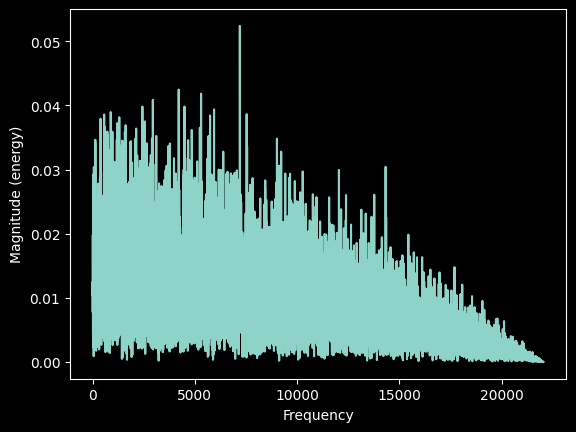

In [83]:
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

h = [1,1] #impulse response / filter kernel

out = np.convolve(x, h)

plt.magnitude_spectrum(out, Fs=fs)

Depending on the length of the filter or number of taps (how many samples we are delaying), we can change the filter to resemble our feedforward comb filter.

$$y[n] = x[n] + x[n-7]$$

$$h[n] = [1, 0, 0, 0, 0, 0 , 0, 1]

(array([3.40171769e-02, 2.21490024e-02, 1.35772666e-02, ...,
        6.10903009e-05, 4.84792571e-05, 1.36251445e-05]),
 array([0.00000000e+00, 1.99936528e+00, 3.99873056e+00, ...,
        2.20450016e+04, 2.20470010e+04, 2.20490003e+04]),
 <matplotlib.lines.Line2D at 0x7f9174e39cc0>)

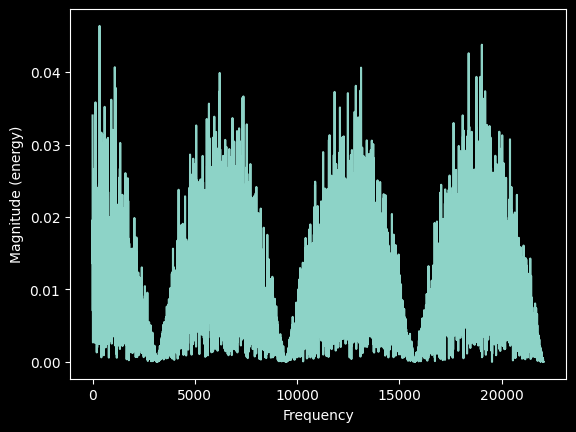

In [81]:
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

h = [1, 0, 0, 0, 0, 0 , 0, 1] # impulse response/ filter kernel

out = np.convolve(x, h)

plt.magnitude_spectrum(out, Fs=fs)

We can also define moving average filter by averaging across a specified window. This filter smooths a signal by averaging a number of consecutive samples.
 
$$ y[n] = \frac{1}{M} \sum_{k=0}^{M-1} x[n-k]$$
 
This is equivalent to convolving $x[n]$ with a filter $h[n]$ of length $M$:

$$ h[n] = \frac{1}{M}, \quad 0 \leq n < M $$

This also creates a low pass filter.

(array([7.62400757e-03, 7.50794526e-03, 1.02529044e-02, ...,
        1.91222317e-06, 1.41164683e-06, 1.43488256e-07]),
 array([0.00000000e+00, 1.99918401e+00, 3.99836801e+00, ...,
        2.20450020e+04, 2.20470012e+04, 2.20490004e+04]),
 <matplotlib.lines.Line2D at 0x7f9174eb1900>)

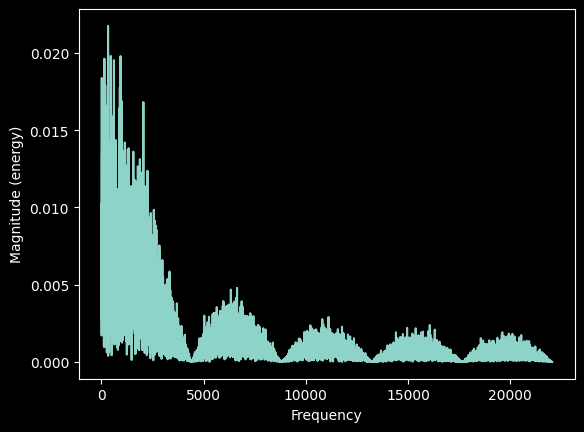

In [82]:
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

# Define a moving average filter (M = 10)
M = 10
h = np.ones(M) / M  # Filter kernel
out = np.convolve(x, h) 

plt.magnitude_spectrum(out, Fs=fs)

### For your curiosity
As we've discussed, the problem with filter design is that its frequency response is not directly defined in Hz. It depends on the filter’s impulse response length and shape. 

To get precise frequency control, we need to connect time-domain parameters (e.g., filter length, shape) to their frequency-domain behavior.
 
 To achieve a **specific cutoff frequency** \( f_c \) in Hz for a moving average filter, we can determine the required filter length \( M \).
 
 The relationship between the filter length and cutoff frequency is roughly:
 
$$
 M = \frac{0.443 f_s}{f_c}
$$
 
 - **\( f_s \)** is the sampling frequency in Hz.
 - **\( f_c \)** is the desired cutoff frequency in Hz.
 - **\( M \)** is the number of samples in the moving average filter.
 
 
 **Example: Designing a Moving Average Filter with a Specific Cutoff**
 
 Suppose we want a **1 kHz low-pass filter** at a sampling rate of **10 kHz**:
$$
 M = \frac{0.443 \times 10000}{1000} = 4.43
$$
 
 Since \( M \) must be an integer, we round to \( M = 4 \) or \( M = 5 \).

## Filters and the frequency response

In the example above, we can filter the signal by simple convolution or a windowed "averaging" of the signal over time. The length of the window will affect how much 'smoothing' of the signal there is and therefore a greater value of $M$ will lead to greater high-frequency removal. (High frequencies change "too fast" so are not captured in the averaging)

Here our impulse response is a rectangular window and we get a kind of lowpass filter. However, this is a very particular frequency response. A flat line (rectangle window) in the time domain yields a sinc function in the frequency domain.

This relationship between a rectangle window and sinc function is very important for constructing ideal filters.

#### Understanding the Sinc Function in lowpass filtering
 
 The sinc function is fundamental in signal processing because it defines the *ideal* low-pass filter in the time domain, meaning it perfectly passes frequencies below a certain cutoff and blocks everything else.
 
 The sinc function is given by:
 

$$ \text{sinc}(x) = \frac{\sin(\pi x)}{\pi x} $$

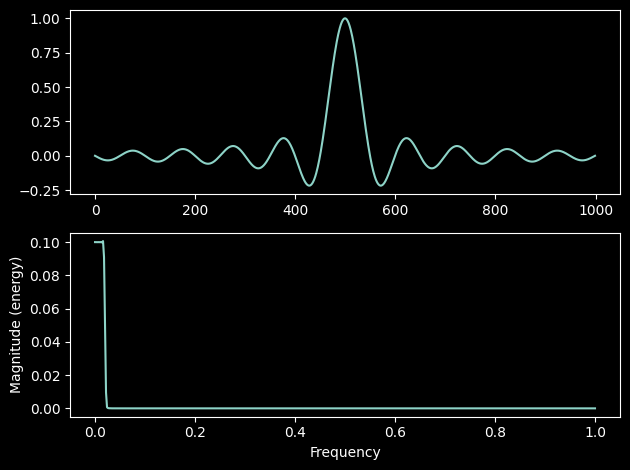

In [ ]:
x = np.linspace(-10, 10, 1000)
sinc_func = np.sinc(x)  # NumPy's sinc(x) is normalized as sin(pi*x)/(pi*x)

plt.subplot(2, 1, 1)
plt.plot(sinc_func);
plt.subplot(2, 1, 2)
plt.magnitude_spectrum(sinc_func);
plt.tight_layout()

A true sinc function is **infinite**, so we must truncate it in practice. However, the sinc function oscillates, which causes some artifacts when truncated. To create a practical low-pass filter, we **multiply sinc by a window function** (e.g., Hamming window).
  
A common FIR low-pass filter is the **Hamming-windowed sinc filter**, which avoids the sharp cutoffs of a simple moving average. Essentially we 'smooth the ends' of the filter to avoid these artifacts, much like in fourier applications like the short time fourier transform.

Effectively, the filter (window) applies a weighted sum of delayed inputs to shape the output.
 

Let's use a windowed sinc function for our impulse response. 

(array([4.86063097e-03, 2.97046458e-03, 2.85845304e-03, ...,
        4.32658718e-06, 9.76770875e-07, 3.15231114e-06]),
 array([0.00000000e+00, 1.99547511e+00, 3.99095023e+00, ...,
        2.20460090e+04, 2.20480045e+04, 2.20500000e+04]),
 <matplotlib.lines.Line2D at 0x7f91747c8220>)

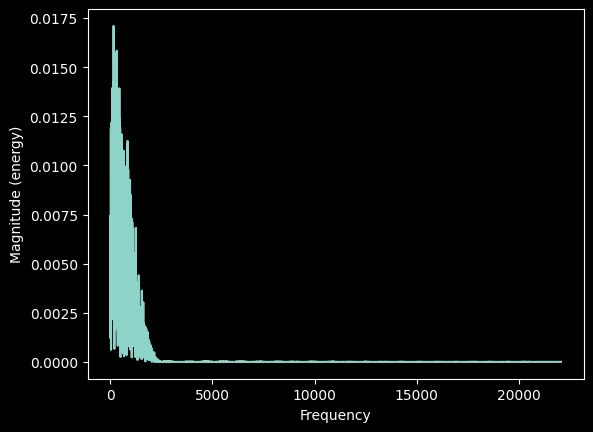

In [ ]:
# with some help from ChatGPT
fs = 44100
dur = 0.5
x = np.random.normal(0, 1, int(fs*dur))

# this is our filter length
num_taps = 51
# this creates the time scale for sinc centered around 0
n = np.arange(num_taps) - (num_taps - 1) / 2
cutoff = 1000

sinc_func = 2 * cutoff / fs * np.sinc(2 * cutoff * n / fs)

window = np.hamming(num_taps)
h = sinc_func * window
h /= np.sum(h) # normalize

out = np.convolve(x, h)
plt.magnitude_spectrum(out, Fs=fs)


There is also a numpy function specifically for windowed FIR filters (or the windowed sinc).

(array([5.24807677e-03, 6.03067494e-03, 6.24874678e-03, ...,
        3.11475416e-06, 4.07315519e-06, 2.99168767e-06]),
 array([0.00000000e+00, 1.99547511e+00, 3.99095023e+00, ...,
        2.20460090e+04, 2.20480045e+04, 2.20500000e+04]),
 <matplotlib.lines.Line2D at 0x7f917611bdf0>)

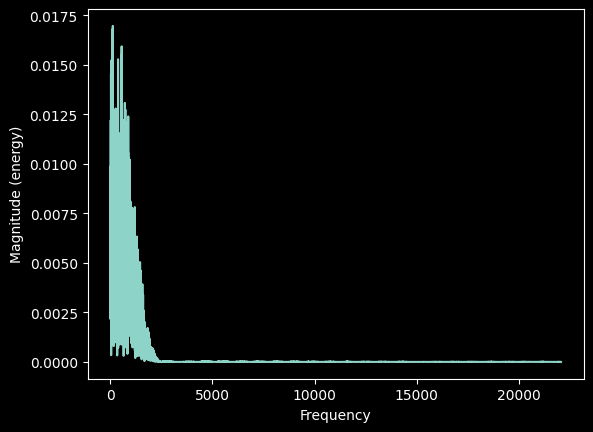

In [89]:
from scipy.signal import firwin

num_taps = 51
cutoff = 1000
h = firwin(num_taps, cutoff, window="hamming", fs=fs)

out = np.convolve(x, h)
plt.magnitude_spectrum(out, Fs=fs)

### Notes for activity: Implementing convolution from scratch

In [27]:
out1 = f[0]*g[0]
out2 = f[0]*g[1] + f[1]*g[0]
out3 = f[0]*g[2] + f[1]*g[1] + f[2]*g[0]
out4 = f[0]*g[3] + f[1]*g[2] + f[2]*g[1] + f[3]*g[0]

out = np.array([out1, out2, out3, out4])
out

array([ 2, 14, 27, 35])

We can also think about implementing this going down the f signal.

In [31]:
g0 = f[0] * g
g0

array([ 2, 10,  4,  6,  8])

In [32]:
g1 = f[1] * g
g1

array([ 4, 20,  8, 12, 16])

However, we'd need to line them up with time shifts and add down the column.

|   |   |   |   |   |   |   |   | |
|-|-|-|-|-|-|-|-|-|
T3|   |   |   | 6  | 30  | 12  | 18 | 24  |
T2|   |   |  3 | 15  | 6  | 9  | 12  |   |
T1|   |  4 | 20  | 8  | 12  | 16  |   |   |
T0|  2 | 10  | 4  | 6  | 8  |   |   |   |

Note, the output length of convolution will always be the (length of f + length of g - 1). 

In [35]:
out = np.convolve(f, g)
len1 = len(f)+len(g)-1
len2 = len(out)
len1==len2

True

Also, note that convolution is commutative. It does not matter the order you convolve $f*g$ or $g*f$

In [39]:
out1 = np.convolve(f, g)
out2 = np.convolve(g, f)
np.array_equal(out1, out2)

True